# No-Press Diplomacy - Data Integration & EDA

**Project:** Improve Self-Play for Diplomacy  
**Authors:** Giacomo Colosio, Maciej Tasarz, Jakub Seliga, Luka Ivcevic  
**Course:** ISP - UPC Barcelona, Fall 2025/26

---

## 1. Setup

In [1]:
import json
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np

print('Setup complete!')

Setup complete!


## 2. Constants

In [2]:
POWERS = ['AUSTRIA', 'ENGLAND', 'FRANCE', 'GERMANY', 'ITALY', 'RUSSIA', 'TURKEY']

SUPPLY_CENTERS = [
    'ANK', 'BEL', 'BER', 'BRE', 'BUD', 'BUL', 'CON', 'DEN', 'EDI', 'GRE',
    'HOL', 'KIE', 'LON', 'LVP', 'MAR', 'MOS', 'MUN', 'NAP', 'NWY', 'PAR',
    'POR', 'ROM', 'RUM', 'SER', 'SEV', 'SMY', 'SPA', 'STP', 'SWE', 'TRI',
    'TUN', 'VEN', 'VIE', 'WAR'
]

HOME_CENTERS = {
    'AUSTRIA': ['BUD', 'TRI', 'VIE'],
    'ENGLAND': ['EDI', 'LON', 'LVP'],
    'FRANCE': ['BRE', 'MAR', 'PAR'],
    'GERMANY': ['BER', 'KIE', 'MUN'],
    'ITALY': ['NAP', 'ROM', 'VEN'],
    'RUSSIA': ['MOS', 'SEV', 'STP', 'WAR'],
    'TURKEY': ['ANK', 'CON', 'SMY']
}

DATA_PATH = '../data/standard_no_press.jsonl'

print(f'Powers: {len(POWERS)}')
print(f'Supply centers: {len(SUPPLY_CENTERS)} (need 18 to win)')

Powers: 7
Supply centers: 34 (need 18 to win)


## 3. Load Data

In [3]:
MAX_GAMES = 5000  # Adjust based on your PC's memory

print(f'Loading up to {MAX_GAMES} games...')
games = []
with open(DATA_PATH, 'r') as f:
    for i, line in enumerate(f):
        if i >= MAX_GAMES:
            break
        games.append(json.loads(line))
        if (i + 1) % 1000 == 0:
            print(f'  Loaded {i + 1} games...')

print(f'\nTotal loaded: {len(games)} games')

Loading up to 5000 games...
  Loaded 1000 games...
  Loaded 2000 games...
  Loaded 3000 games...
  Loaded 4000 games...
  Loaded 5000 games...

Total loaded: 5000 games


## 4. Basic Statistics

In [4]:
# Collect statistics
phase_counts = []
year_counts = []
winners = Counter()
order_types = Counter()
total_orders = 0
openings = defaultdict(list)

for game in games:
    phases = game.get('phases', [])
    phase_counts.append(len(phases))
    
    # Count years
    years = set()
    for p in phases:
        name = p.get('name', '')
        if len(name) >= 5:
            try:
                years.add(int(name[1:5]))
            except:
                pass
    year_counts.append(len(years))
    
    # Find winner
    winner = None
    if phases:
        last_state = phases[-1].get('state', {})
        centers = last_state.get('centers', {})
        for power, cs in centers.items():
            if len(cs) >= 18:
                winner = power
                break
    winners[winner if winner else 'Draw'] += 1
    
    # Count orders and openings
    for phase in phases:
        phase_name = phase.get('name', '')
        for power, orders in phase.get('orders', {}).items():
            if orders is None:
                continue
            
            # Save S1901M openings
            if phase_name == 'S1901M':
                openings[power].append(tuple(sorted(orders)))
            
            for order in orders:
                total_orders += 1
                if ' H' in order:
                    order_types['HOLD'] += 1
                elif ' - ' in order:
                    order_types['MOVE'] += 1
                elif ' S ' in order:
                    order_types['SUPPORT'] += 1
                elif ' C ' in order:
                    order_types['CONVOY'] += 1
                elif ' B' in order:
                    order_types['BUILD'] += 1
                elif ' D' in order:
                    order_types['DISBAND'] += 1
                else:
                    order_types['OTHER'] += 1

print('Statistics computed!')

Statistics computed!


In [5]:
print('='*60)
print('DATASET SUMMARY')
print('='*60)
print(f'Total games: {len(games):,}')
print(f'\nPhases per game:')
print(f'  Min: {min(phase_counts)}')
print(f'  Max: {max(phase_counts)}')
print(f'  Mean: {np.mean(phase_counts):.1f}')
print(f'  Median: {np.median(phase_counts):.1f}')
print(f'\nYears per game:')
print(f'  Min: {min(year_counts)}')
print(f'  Max: {max(year_counts)}')
print(f'  Mean: {np.mean(year_counts):.1f}')
print(f'\nTotal orders: {total_orders:,}')
print(f'Avg orders per game: {total_orders/len(games):.1f}')
print('='*60)

DATASET SUMMARY
Total games: 5,000

Phases per game:
  Min: 5
  Max: 413
  Mean: 34.7
  Median: 32.0

Years per game:
  Min: 2
  Max: 100
  Mean: 8.7

Total orders: 2,607,178
Avg orders per game: 521.4


## 5. Winner Distribution

In [6]:
print('\nWINNER DISTRIBUTION')
print('-'*40)
for power in POWERS + ['Draw']:
    count = winners.get(power, 0)
    pct = count / len(games) * 100
    bar = '█' * int(pct / 2)
    print(f'{power:10s}: {count:5d} ({pct:5.1f}%) {bar}')


WINNER DISTRIBUTION
----------------------------------------
AUSTRIA   :   749 ( 15.0%) ███████
ENGLAND   :   159 (  3.2%) █
FRANCE    :   619 ( 12.4%) ██████
GERMANY   :   560 ( 11.2%) █████
ITALY     :   335 (  6.7%) ███
RUSSIA    :   172 (  3.4%) █
TURKEY    :   313 (  6.3%) ███
Draw      :  2093 ( 41.9%) ████████████████████


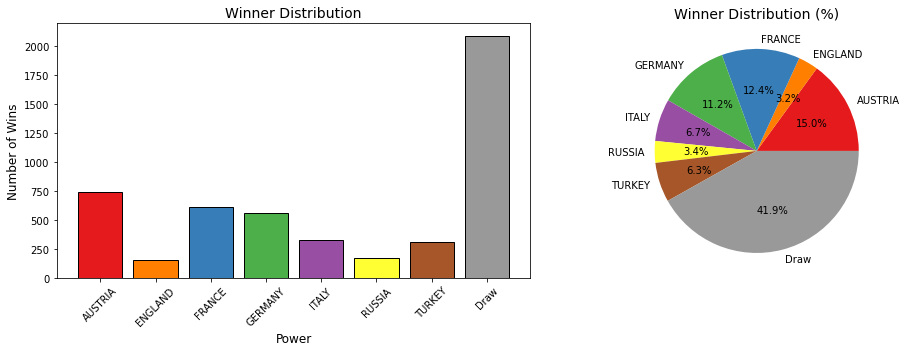

In [7]:
# Winner bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels = POWERS + ['Draw']
counts = [winners.get(p, 0) for p in labels]
colors = ['#e41a1c', '#ff7f00', '#377eb8', '#4daf4a', '#984ea3', '#ffff33', '#a65628', '#999999']

axes[0].bar(labels, counts, color=colors, edgecolor='black')
axes[0].set_xlabel('Power', fontsize=12)
axes[0].set_ylabel('Number of Wins', fontsize=12)
axes[0].set_title('Winner Distribution', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

axes[1].pie(counts, labels=labels, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Winner Distribution (%)', fontsize=14)

plt.tight_layout()
plt.savefig('winner_distribution.png', dpi=150)
plt.show()

## 6. Game Length Distribution

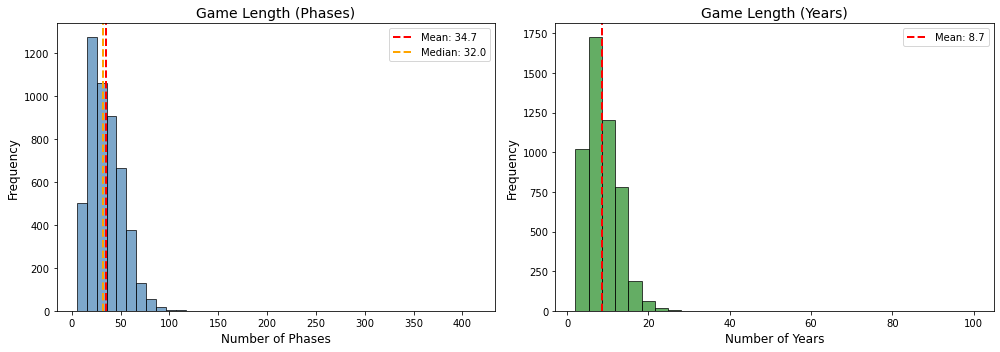

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Phases histogram
axes[0].hist(phase_counts, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(np.mean(phase_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(phase_counts):.1f}')
axes[0].axvline(np.median(phase_counts), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(phase_counts):.1f}')
axes[0].set_xlabel('Number of Phases', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Game Length (Phases)', fontsize=14)
axes[0].legend()

# Years histogram
axes[1].hist(year_counts, bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
axes[1].axvline(np.mean(year_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(year_counts):.1f}')
axes[1].set_xlabel('Number of Years', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Game Length (Years)', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.savefig('game_length_distribution.png', dpi=150)
plt.show()

## 7. Order Type Analysis

In [9]:
print('\nORDER TYPE DISTRIBUTION')
print('-'*40)
for otype, count in order_types.most_common():
    pct = count / total_orders * 100
    bar = '█' * int(pct / 2)
    print(f'{otype:10s}: {count:8,} ({pct:5.1f}%) {bar}')


ORDER TYPE DISTRIBUTION
----------------------------------------
MOVE      : 1,612,688 ( 61.9%) ██████████████████████████████
HOLD      :  420,758 ( 16.1%) ████████
SUPPORT   :  326,780 ( 12.5%) ██████
BUILD     :  166,407 (  6.4%) ███
DISBAND   :   41,542 (  1.6%) 
OTHER     :   39,003 (  1.5%) 


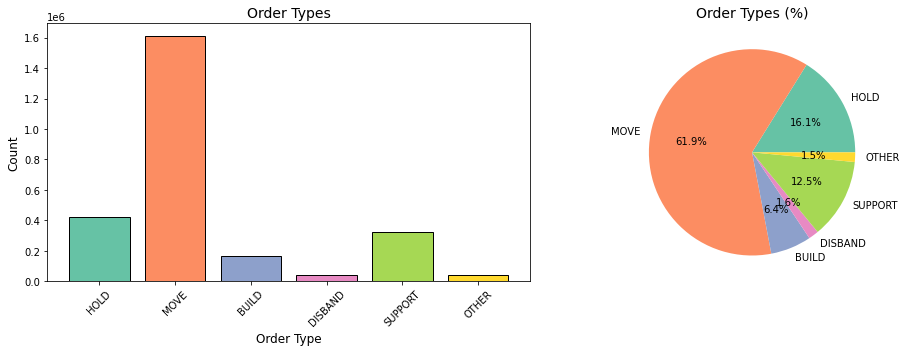

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

order_labels = list(order_types.keys())
order_counts = list(order_types.values())

# Bar chart
colors = plt.cm.Set2(range(len(order_labels)))
axes[0].bar(order_labels, order_counts, color=colors, edgecolor='black')
axes[0].set_xlabel('Order Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Order Types', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(order_counts, labels=order_labels, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Order Types (%)', fontsize=14)

plt.tight_layout()
plt.savefig('order_distribution.png', dpi=150)
plt.show()

## 8. Opening Analysis (Spring 1901)

In [11]:
print('\n' + '='*60)
print('OPENING ANALYSIS - Spring 1901 Movement')
print('='*60)

for power in POWERS:
    print(f'\n{power}:')
    counter = Counter(openings[power])
    total = len(openings[power])
    for opening, count in counter.most_common(3):
        pct = count / total * 100 if total > 0 else 0
        print(f'  [{count:4d} games, {pct:5.1f}%]')
        for order in opening:
            print(f'    - {order}')


OPENING ANALYSIS - Spring 1901 Movement

AUSTRIA:
  [ 882 games,  20.4%]
    - A BUD - SER
    - A VIE - GAL
    - F TRI - ALB
  [ 427 games,   9.9%]
    - A BUD - SER
    - A VIE - TRI
    - F TRI - ALB
  [ 269 games,   6.2%]
    - A BUD - SER
    - A VIE - GAL
    - F TRI - VEN

ENGLAND:
  [ 940 games,  30.2%]
    - A LVP - YOR
    - F EDI - NWG
    - F LON - NTH
  [ 838 games,  26.9%]
    - A LVP - EDI
    - F EDI - NWG
    - F LON - NTH
  [ 616 games,  19.8%]
    - A LVP - YOR
    - F EDI - NTH
    - F LON - ENG

FRANCE:
  [ 743 games,  17.2%]
    - A MAR S A PAR - BUR
    - A PAR - BUR
    - F BRE - MAO
  [ 567 games,  13.1%]
    - A MAR - SPA
    - A PAR - BUR
    - F BRE - MAO
  [ 462 games,  10.7%]
    - A MAR - BUR
    - A PAR - PIC
    - F BRE - ENG

GERMANY:
  [1113 games,  29.4%]
    - A BER - KIE
    - A MUN - RUH
    - F KIE - DEN
  [ 495 games,  13.1%]
    - A BER - KIE
    - A MUN - RUH
    - F KIE - HOL
  [ 487 games,  12.9%]
    - A BER - KIE
    - A MUN - BUR
    - 

## 9. Power Performance Over Time

In [12]:
# Track supply centers over time for each power
max_year = 1920
power_centers_by_year = {p: defaultdict(list) for p in POWERS}

for game in games[:1000]:  # Sample for speed
    phases = game.get('phases', [])
    for phase in phases:
        name = phase.get('name', '')
        if not name.startswith('W'):  # Winter phases have final year counts
            continue
        try:
            year = int(name[1:5])
            if year > max_year:
                continue
        except:
            continue
        
        state = phase.get('state', {})
        centers = state.get('centers', {})
        for power in POWERS:
            num_centers = len(centers.get(power, []))
            power_centers_by_year[power][year].append(num_centers)

# Calculate averages
years = sorted(set(y for p in power_centers_by_year.values() for y in p.keys()))
avg_centers = {p: [] for p in POWERS}
for year in years:
    for power in POWERS:
        vals = power_centers_by_year[power].get(year, [])
        avg_centers[power].append(np.mean(vals) if vals else np.nan)

print(f'Tracked years: {min(years)} - {max(years)}')

Tracked years: 1901 - 1920


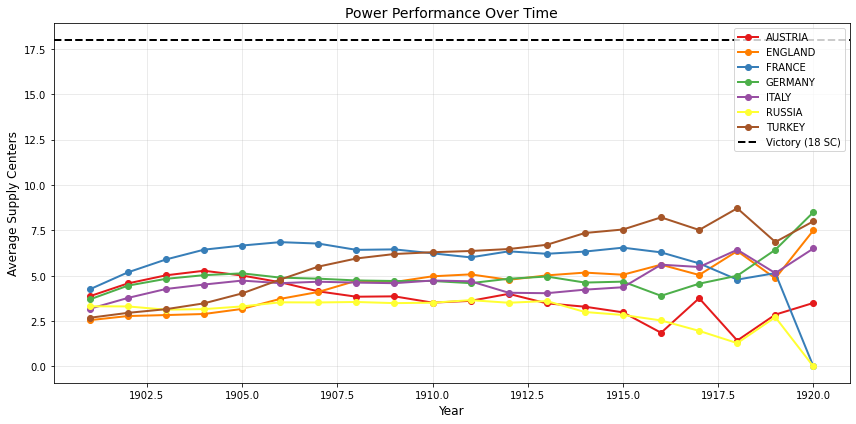

In [13]:
plt.figure(figsize=(12, 6))

colors = ['#e41a1c', '#ff7f00', '#377eb8', '#4daf4a', '#984ea3', '#ffff33', '#a65628']
for i, power in enumerate(POWERS):
    plt.plot(years, avg_centers[power], marker='o', label=power, color=colors[i], linewidth=2)

plt.axhline(y=18, color='black', linestyle='--', linewidth=2, label='Victory (18 SC)')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Supply Centers', fontsize=12)
plt.title('Power Performance Over Time', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('power_performance.png', dpi=150)
plt.show()

## 10. Create Train/Val/Test Split

In [14]:
import random
random.seed(42)

# Shuffle games
indices = list(range(len(games)))
random.shuffle(indices)

# Split 80/10/10
n = len(games)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

print(f'Dataset splits:')
print(f'  Train: {len(train_idx):,} games (80%)')
print(f'  Val:   {len(val_idx):,} games (10%)')
print(f'  Test:  {len(test_idx):,} games (10%)')

Dataset splits:
  Train: 4,000 games (80%)
  Val:   500 games (10%)
  Test:  500 games (10%)


In [15]:
# Save splits
os.makedirs('../data/processed', exist_ok=True)

def save_split(indices, filename):
    with open(filename, 'w') as f:
        for idx in indices:
            f.write(json.dumps(games[idx]) + '\n')
    print(f'Saved: {filename}')

save_split(train_idx, '../data/processed/train.jsonl')
save_split(val_idx, '../data/processed/val.jsonl')
save_split(test_idx, '../data/processed/test.jsonl')

print('\nData splits saved!')

Saved: ../data/processed/train.jsonl
Saved: ../data/processed/val.jsonl
Saved: ../data/processed/test.jsonl

Data splits saved!


## 11. Summary

### Key Findings:
1. **Game Length**: Average ~35 phases (~12 years)
2. **Draws Common**: ~42% of games end in draw
3. **Austria Strongest**: Highest solo win rate (~16%)
4. **Russia/England Weakest**: Lowest win rates (~3%)
5. **Order Distribution**: 62% MOVE, 16% HOLD, 13% SUPPORT

### Next Steps:
1. Implement state encoding (887-dimensional)
2. Train behavioral cloning model
3. Add self-play with human regularization

In [16]:
print('\n' + '='*60)
print('EDA COMPLETE!')
print('='*60)
print(f'\nGames analyzed: {len(games):,}')
print(f'Total orders: {total_orders:,}')
print(f'\nFiles saved:')
print('  - winner_distribution.png')
print('  - game_length_distribution.png')
print('  - order_distribution.png')
print('  - power_performance.png')
print('  - ../data/processed/train.jsonl')
print('  - ../data/processed/val.jsonl')
print('  - ../data/processed/test.jsonl')


EDA COMPLETE!

Games analyzed: 5,000
Total orders: 2,607,178

Files saved:
  - winner_distribution.png
  - game_length_distribution.png
  - order_distribution.png
  - power_performance.png
  - ../data/processed/train.jsonl
  - ../data/processed/val.jsonl
  - ../data/processed/test.jsonl
